# Анализ сервиса аренды самокатов GoFast

**Описание проекта:** В нашем распоряжении данные о некоторых пользователях сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках. Анализ данных и проверка некоторых гипотез поможет составить некоторые рекомендации бизнесу, чтобы помочь ему вырасти.

**Цель исследования:** Мы проанализируем данные и проверим некоторые гипотезы, чтобы дать рекомендации рекламноу отделу касательно продвижения конкретного типа подписки (платной или бесплатной).

**Ход исследования:**

1. Загрузка данных и изучение датасетов с информацией о пользователях, о поездках и о подписке.
2. Предобработка данных. Работа с типами данных, пропущенными значениями, дубликатами и создание новых столбцов.
3. Исследовательский анализ данных. Работа с данными по городам, типе подписки, возрасте пользователей, расстоянии и продолжительности поездок.
4. Объединение данных. Создание общего датафрейма с информацией о пользователях, поездках и наличии подписки, а также отдельных датасетов по пользователям с подпиской и без подписки с последующим анализом.
5. Подсчёт выручки.Создание датафрейма с агрегированными данными о поездках и добавление в него информации о помесячной выручке, которую принёс каждый пользователь, с последующим анализом.
6. Проверка гипотез:
- Тратят ли пользователи с подпиской больше времени на поездки?
- Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
7. Общий вывод.

**Описание сервиса:**

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1. Без подписки
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;
2. С подпиской Ultra
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import binom
import scipy.stats as st

## Загрузка данных

### Описание данных

**Пользователи — users_go.csv**
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

In [2]:
try:
    users = pd.read_csv('C:/Users/glebm/Desktop/dataset/users_go.csv')
except:
    users = pd.read_csv('/datasets/users_go.csv')
    
display(users.head())
display(users.info())
print(users['city'].unique())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи']


Общая информация о датафрейме users_go.csv: в датафрейме представлена выборка пользователей из 8 городов, представлены уникальные ID пользователей, их имя, возраст и формат подписки. Всего пользователей в выборке 1565, этого для анализа достаточно. 

**Поездки — rides_go.csv**
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

In [3]:
try:
    rides = pd.read_csv('C:/Users/glebm/Desktop/dataset/rides_go.csv')
except:
    rides = pd.read_csv('/datasets/rides_go.csv')
    
display(rides.head())
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Общая информация о датафрейме rides_go.csv: В датафрейме представлено 18068 записей о поездках пользователей (поездок сильно больше, чем самих пользователей), есть данные об ID пользователя, дистанции, продолжительности поездки в минутах и дате её совершения. Столбец date требует замены типа данных. 

**Подписки — subscriptions_go.csv**
- `subscription_type` - тип подписки
- `minute_price` -	стоимость одной минуты поездки по данной подписке
- `start_ride_price` -	стоимость начала поездки
- `subscription_fee` -	стоимость ежемесячного платежа

In [4]:
try:
    subscriptions = pd.read_csv('C:/Users/glebm/Desktop/dataset/subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    
display(subscriptions.head())
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Общая информация о датафрейме subscriptions_go.csv: в датафрейме содержится информация только о двух типах подписки, для каждого типа указана стоимость одной минуты поездки, начала поездки и ежемесячного платежа. 

### Общая информация о датафреймах

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи — users_go.csv**. В датафрейме представлена выборка пользователей из 8 городов, представлены уникальные ID пользователей, их имя, возраст и формат подписки. Всего пользователей в выборке 1565, этого для анализа достаточно. 

**Поездки — rides_go.csv**. В датафрейме представлено 18068 записей о поездках пользователей (поездок сильно больше, чем самих пользователей), есть данные об ID пользователя, дистанции, продолжительности поездки в минутах и дате её совершения. 

**Подписки — subscriptions_go.csv**. В датафрейме содержится информация только о двух типах подписки, для каждого типа указана стоимость одной минуты поездки, начала поездки и ежемесячного платежа. 

В дальнейшем данные можно будет объединить по ID пользователя и типу подписки. 

## Предобработка данных

### Изменение типа данных 

Приводим столбец date к типу даты pandas.

In [5]:
rides['date'] = pd.to_datetime(rides['date'])

### Создание новых столбцов

Создаем новый столбец с номером месяца на основе столбца date в датафрейме rides.

In [6]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Проверка на пропуски и дубликаты

Проверяем наличие пропущенных значений и дубликатов в датафреймах.

In [7]:
print(users.duplicated().sum())
print(rides.duplicated().sum())
print(subscriptions.duplicated().sum())

31
0
0


In [8]:
users = users.drop_duplicates() #удаляем 31 явный дубль из датафрейма users

In [9]:
print(users.isnull().sum()) #определяем, в каких датафреймах есть пропуски

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


In [10]:
print(rides.isnull().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


In [11]:
print(subscriptions.isnull().sum())

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Пропуски ни в одном датафрейме не обнаружены.

### Предобработка данных: выводы
- Столбец date в датафрейме rides приведен к типу даты pandas
- Создан новый столбец с номером месяца на основе столбца date в датафрейме rides.
- Неявные дубликаты и пропуски в датафреймах не обнаружены
- Удален 31 явный дубликат из датафрейма users

## Исследовательский анализ данных

В этом шаге мы опишем и визуализируем общую информацию о пользователях и поездках.

### Частота встречаемости городов

In [12]:
grouped_users = users.groupby('city').count().reset_index() #группируем данные по городам 
sorted_users = grouped_users.sort_values(by='age', ascending=False) #сортируем данные

,city,user_id,name,age,subscription_type
0,Пятигорск,219,219,219,219
1,Екатеринбург,204,204,204,204
2,Ростов-на-Дону,198,198,198,198
3,Краснодар,193,193,193,193
4,Сочи,189,189,189,189
5,Омск,183,183,183,183
6,Тюмень,180,180,180,180
7,Москва,168,168,168,168


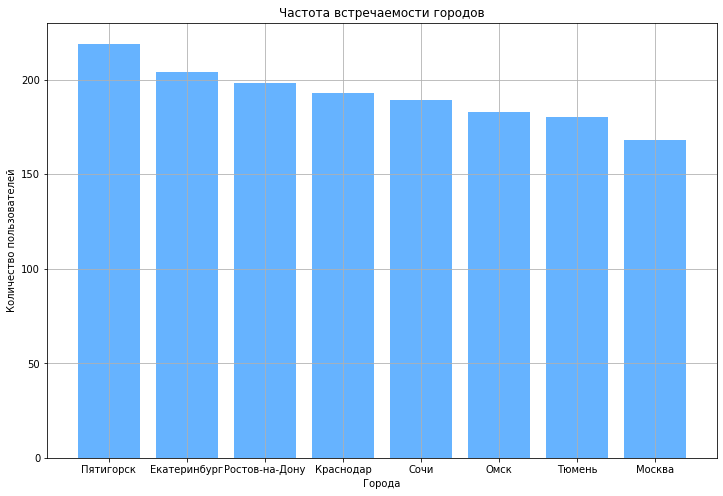

In [13]:
#строим гистограмму по количеству пользователей в разных городах
plt.figure(figsize=(12, 8))
plt.bar(sorted_users['city'], sorted_users['age'], color='#66b3ff')
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Количество пользователей')
plt.grid(True)

#выводим таблицу с числовыми значениями также для наглядности
sorted_users.reset_index(drop=True)

**Комментарий:** По графику мы видим, что явным лидером по количеству пользователей среди 8 городов выборки является Пятигорск, меньше всего пользователей в Москве. Но в целом их количество по городам примерно одинаковое: от 150 до 250 пользователей.

### Соотношение пользователей с подпиской и без подписки

In [14]:
#создаем таблицу, где можно увидеть количество пользователей с подпиской или без и их долю 
sub_users = users['subscription_type'].value_counts().reset_index()
sub_users.columns = ['subscription_type', 'count']
sub_users['%'] = round((sub_users['count'] / users.shape[0]) * 100, 1)

sub_users

,subscription_type,count,%
0,free,835,54.4
1,ultra,699,45.6


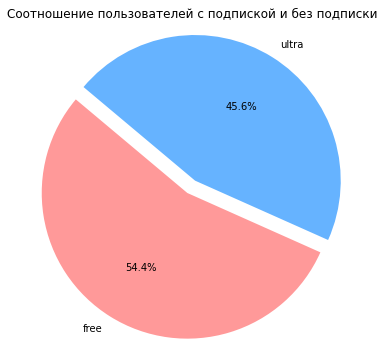

In [15]:
#строим круговую диаграмму для наглядности
plt.figure(figsize=(6, 6))
plt.pie(sub_users['count'], 
        explode=(0.1, 0),  #выделим сектор с 'free' 
        labels=sub_users['subscription_type'], 
        colors=['#ff9999','#66b3ff'], 
        autopct='%1.1f%%',  
        startangle=140)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.axis('equal')
plt.show()

**Комментарий:** Почти половина пользователей используют подписку. 

### Возраст пользователей

In [16]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Средний возраст пользователей - примерно 25 лет. Первый и третий квартили показывают, что основная масса пользователей находятся в возрасте от 22 до 28 лет. Минимальный возраст - 12 лет, максимальный - 43.

Для наглядности построим график с нормальным распределением возраста пользователей. 

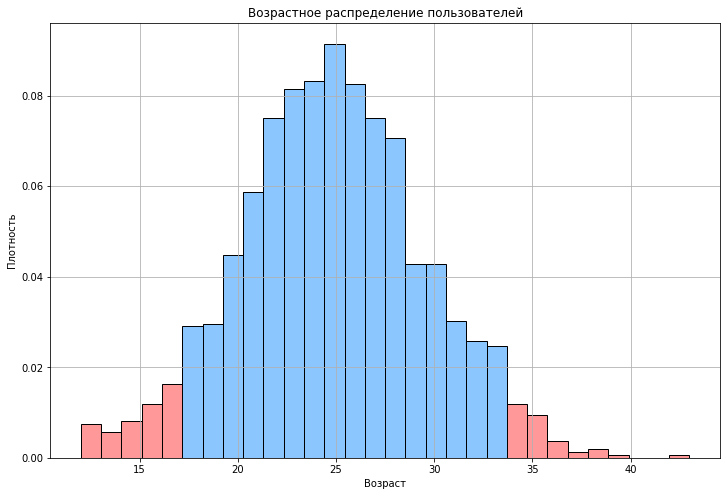

In [17]:
plt.figure(figsize=(12, 8))

ax = sns.histplot(users['age'], bins=30, stat='density', color='#66b3ff', edgecolor='black')

bars = ax.patches 
for bar in bars:
    if bar.get_height() < 0.02:
        bar.set_facecolor('#ff9999')

plt.title('Возрастное распределение пользователей')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.grid(True)

plt.show()

**Комментарий**: График подтверждает выведенные из возрастной статистики данные. Также видно, что совсем редкими значениями можем считать возраст до 18 лет и старше 33.

### Расстояние, которое пользователь преодолел за одну поездку

In [18]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Среднее расстояние поездки - примерно 3,1 километров. Первый и третий квартили показывают, что основная масса пользователей используют самокат для поездки на расстояние примерно от 2,5 до 3,7 километров. Минимальное значение - 0.8 метра, максимальное расстояние - 7,2 км.

Для наглядности построим график.

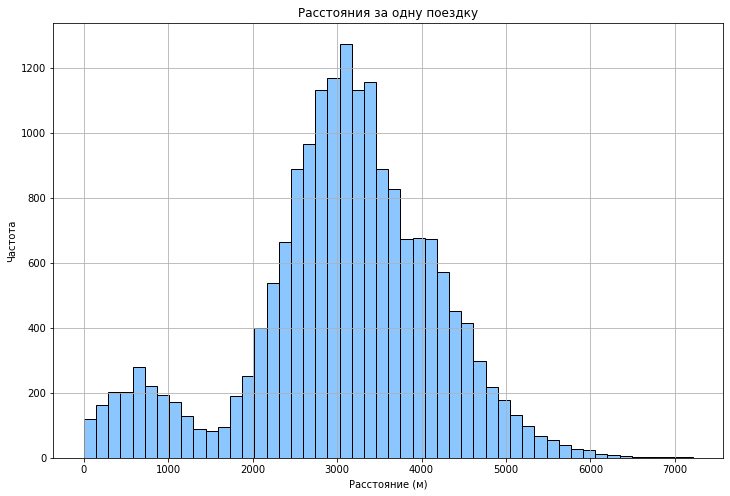

In [19]:
plt.figure(figsize=(12, 8))
sns.histplot(rides['distance'], bins=50, color='#66b3ff', edgecolor='black')
plt.title('Расстояния за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий:** На графике видно, что есть как будто бы две "категории" поездок - на более короткие (до 1 километра) и более длинные дистанции (от 2 километров). В первую категорию могут попадать тестовые поездки пользователей, поэтому их значительно меньше, чем поездок на дистанции в несколько километров. 

### Продолжительность поездок

In [20]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Средняя продолжительность поездки - примерно 17 минут. Первый и третий квартили показывают, что основная масса пользователей используют самокат для одной поездки на протяжении от 13 до 21 минуты. Минимальное значение - полминуты, максимальная продолжительность - 40 минут.

Для наглядности построим график.

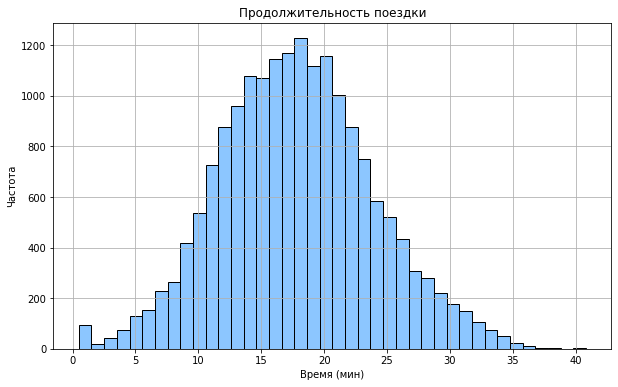

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(rides['duration'], bins=40, color='#66b3ff', edgecolor='black')
plt.title('Продолжительность поездки')
plt.xlabel('Время (мин)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий:** На графике, помимо подтверждения предыдущего вывода, виден выброс у нуля. Возможно, такой выброс связан с тем, что пользователи тестируют приложение или же, проехав на самокате, решают выбрать другой. 

### Исследовательский анализ данных: выводы

- **Города**. Явным лидером по количеству пользователей среди 8 городов выборки является Пятигорск, меньше всего пользователей в Москве. Но в целом их количество по городам примерно одинаковое: от 150 до 250.
- **Подписка**. Почти половина пользователей используют подписку - 45.6%, остальные 54.4% пользователей используют приложение бесплатно.
- **Возраст**. Средний возраст пользователей - примерно 25 лет. Основная масса пользователей находятся в возрасте от 22 до 28 лет, совсем редкими значениями можем считать возраст до 18 лет и старше 33. Минимальный возраст - 12 лет, максимальный - 43.
- **Расстояние**. Среднее расстояние поездки - около 3 километров. Основная масса пользователей используют самокат для поездки на расстояние примерно от 2,5 до 3,7 километров. Минимальное значение - 0.8 метра, максимальное расстояние - 7,2 км.
- **Продолжительность поездок**. Средняя продолжительность поездки - примерно 17 минут. Основная масса пользователей используют самокат для одной поездки на протяжении от 13 до 21 минуты. Минимальное значение - полминуты, максимальная продолжительность - 40 минут. Встречаются выбросы, очень короткие поездки (до 1 минуты) - вероятно, пользователи тестируют или приложение, или самокат, или и то, и то. 

## Объединение данных

### Объединение данные о пользователях, поездках и подписках в один датафрейм

Для объединения датафреймов используем метод `merge()`. Прежде чем объединять датасеты, оцениваем их исходную размерность. 

In [22]:
print(f'Размерность датафрейма rides: {rides.shape}')
print(f'Размерность датафрейма users: {users.shape}')
print(f'Размерность датафрейма subscriptions: {subscriptions.shape}')

Размерность датафрейма rides: (18068, 5)
Размерность датафрейма users: (1534, 5)
Размерность датафрейма subscriptions: (2, 4)


In [23]:
data = pd.merge(rides, users, on='user_id', how='inner')
data_sub = pd.merge(data, subscriptions, on='subscription_type', how='inner')
data = data_sub

data.head(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


После объединения проверяем размерность таблицы, чтобы та совпадала с исходной, а также проверяем наличие пропусков в объединенном датасете.

In [24]:
print(f'Размерность объединенного датафрейма: {data.shape}')
print(f'Количество пропущенных значений в объединенном датафрейме: {data.isnull().sum()}')

Размерность объединенного датафрейма: (18068, 12)
Количество пропущенных значений в объединенном датафрейме: user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Размерность таблицы сохранена (18068 значений), пропусков в объединенном датафрейме нет. 

### Создание датафреймов с информацией о пользователях без подписки и с подпиской

In [25]:
data_free = data[data['subscription_type'] == 'free'].copy() #датафрейм без подписки
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [26]:
data_ultra = data[data['subscription_type'] == 'ultra'].copy() #датафрейм с подпиской
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


В этом шаге мы создали два датафрейма:
- `data_free` - с информацией о пользователях без подписки
- `data_ultra` - с информацией о пользователях с подпиской

### Визуализация данных о пользователях обеих категорий

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

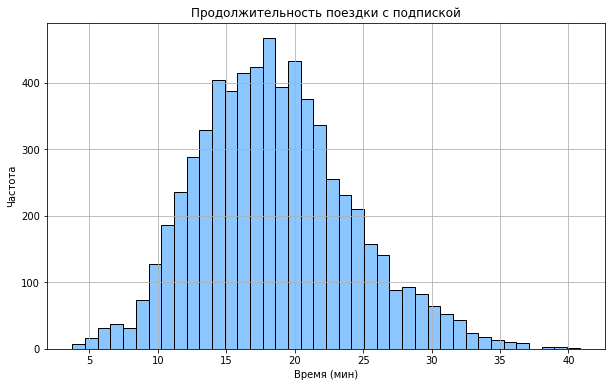

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

<Figure size 720x432 with 0 Axes>

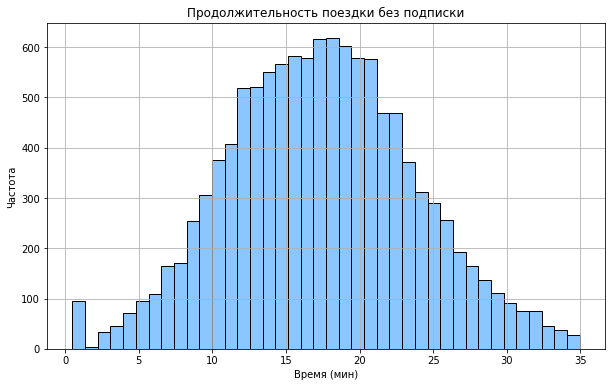

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [27]:
#создаем график по продолжительности поездки пользователей с подпиской
plt.figure(figsize=(10, 6))
sns.histplot(data_ultra['duration'], bins=40, color='#66b3ff', edgecolor='black')
plt.title('Продолжительность поездки с подпиской')
plt.xlabel('Время (мин)')
plt.ylabel('Частота')
plt.grid(True)
plt.show() 

display(data_ultra['duration'].describe()) #добавляем описательную статистику

#создаем график по продолжительности поездки пользователей без подписки
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
sns.histplot(data_free['duration'], bins=40, color='#66b3ff', edgecolor='black')
plt.title('Продолжительность поездки без подписки')
plt.xlabel('Время (мин)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

display(data_free['duration'].describe()) #добавляем описательную статистику

**Комментарий:** Разница по продолжительности поездки не значительная, но есть: без подписки пользователи ездят более короткие по времени дистанции. Также у пользователей без подписки встречается выброс у нуля - видимо, это и есть "проба" приложения и самоката. 

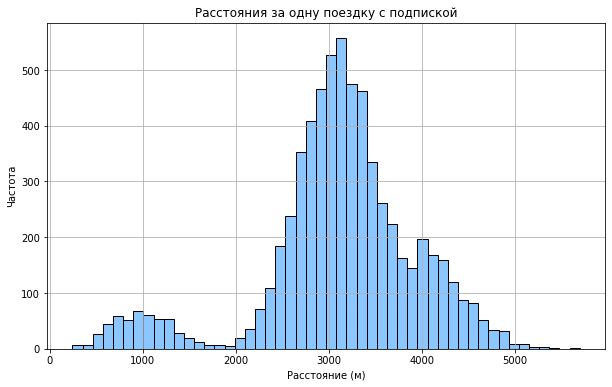

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

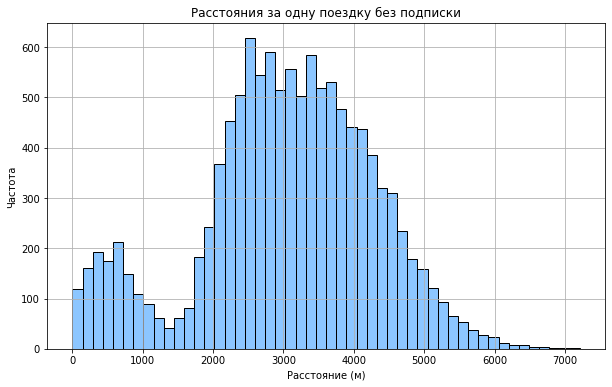

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [28]:
#создаем график по расстоянию одной поездки пользователей с подпиской
plt.figure(figsize=(10, 6))
sns.histplot(data_ultra['distance'], bins=50, color='#66b3ff', edgecolor='black')
plt.title('Расстояния за одну поездку с подпиской')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

display(data_ultra['distance'].describe()) #добавляем описательную статистику

#создаем график по расстоянию одной поездки пользователей без подписки
plt.figure(figsize=(10, 6))
sns.histplot(data_free['distance'], bins=50, color='#66b3ff', edgecolor='black')
plt.title('Расстояния за одну поездку без подписки')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

display(data_free['distance'].describe())  #добавляем описательную статистику

**Комментарий**: Очевидно из графиков, что люди с подпиской охотнее проезжают более длительные дистанции, среднее же значение по расстоянию у пользователей без подписки ниже. У пользователей без подписки также больше значений у нуля: видимо, это снова показываются таким образом "пробы" приложения и самоката. 

### Объединение данных: выводы

В этом шаге:
- был создан общий датафрейм с информацией о пользователях, поездках и наличии подписки под названием `data`;
- были созданы датафреймы с информацией о пользователях с подпиской (`data_ultra`) и без подписки (`data_free`);
- была проведена проверка на сохранение размерности исходного датасета и наличие пропущенных значений в новом;
- были созданы и проанализированы графики с информацией и расстоянии и времени поездок для пользователей обеих категорий.

Новые данные:
- Пользователи с подпиской охотнее проезжают более длительные дистанции и более длительные по времени (но незначительно)
- У пользователей без подписки чаще встречаются значения, близкие к нулю, и в продолжительности поездки, и в расстоянии - вероятно, так проявляется то, что люди пробуют само приложение и самокаты, прежде чем начать ездить / приобретать подписку.

## Подсчёт выручки

### Создание датафрейма с суммарной информацией по каждому пользователю

Создаем датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: добавляем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [29]:
data_sum = data.groupby(['user_id', 'month']).agg(
    distance_sum=('distance','sum'),
    trips=('distance','count'),
    duration_sum=('duration','sum')
).reset_index()
data_sum['distance_sum'] = round(data_sum['distance_sum'],2)
data_sum['duration_sum'] = round(data_sum['duration_sum'],2)
display(data_sum.head(20))
print('Средняя суммарная дистанция поездки среди пользователей в месяц:', data_sum['distance_sum'].mean())
print('Среднее количество поездок среди пользователей в месяц:', data_sum['trips'].mean())
print('Средняя суммарная продолжительность поездки среди пользователей в месяц:', data_sum['duration_sum'].mean())

,user_id,month,distance_sum,trips,duration_sum
0,1,1,7027.51,2,41.42
1,1,4,754.16,1,6.23
2,1,8,6723.47,2,44.78
3,1,10,5809.91,2,31.58
4,1,11,7003.50,3,53.40
5,1,12,6751.63,2,27.20
6,2,3,10187.72,3,60.96
7,2,4,6164.38,2,39.05
8,2,6,3255.34,1,13.85
9,2,7,6780.72,2,46.17


Средняя суммарная дистанция поездки среди пользователей в месяц: 4896.362588474098
Среднее количество поездок среди пользователей в месяц: 1.5945635866207748
Средняя суммарная продолжительность поездки среди пользователей в месяц: 28.39120377724826


В этом шаге создан датафрейм с агрегированными данными о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц (`data_sum`).

### Добавление столбца с помесячной выручкой по каждому пользователю

В этот же датафрейм добавляем столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого у нас есть информация об условиях оплаты для подписчиков и тех, у кого нет подписки. 

In [30]:
#находим прибыль среди пользователей с подпиской
data_ultra['duration'] = np.ceil(data_ultra['duration']).astype(int) #округляем продолжительность до следующего целого числа
agg_ultra = data_ultra.groupby(['user_id','month'])['duration'].sum().reset_index()
agg_ultra['revenue'] = agg_ultra['duration'] * 6 + 199
agg_ultra['subscription_type'] = 'ultra'

#находим прибыль среди пользователей без подписки
data_free['duration'] = np.ceil(data_free['duration']).astype(int) #округляем продолжительность до следующего целого числа
agg_free = data_free.groupby(['user_id','month']).agg(
    duration_sum = ('duration','sum'),
    trips = ('duration','count')).reset_index()
agg_free['revenue'] = agg_free['duration_sum'] * 8 + agg_free['trips' ]* 50
agg_free['subscription_type'] = 'free'

In [31]:
#объединяем колонки с прибылью и добавляем результат в основную агрегированную таблицу
agg_all = pd.concat([agg_free, agg_ultra], ignore_index=True, sort=False)
agg_all = agg_all.drop(['duration_sum', 'trips', 'duration'], axis=1)
result = pd.merge(data_sum, agg_all, on=['user_id', 'month'], how='left')
result

,user_id,month,distance_sum,trips,duration_sum,revenue,subscription_type
0,1,1,7027.51,2,41.42,451,ultra
1,1,4,754.16,1,6.23,241,ultra
2,1,8,6723.47,2,44.78,475,ultra
3,1,10,5809.91,2,31.58,391,ultra
4,1,11,7003.50,3,53.40,535,ultra
...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,24.81,308,free
11327,1534,8,7622.45,2,47.21,484,free
11328,1534,9,4928.17,1,22.56,234,free
11329,1534,11,13350.02,4,76.34,824,free


In [32]:
result.groupby('subscription_type')['revenue'].median()

subscription_type
free     274
ultra    337
Name: revenue, dtype: int64

**Комментарий:** 
В этом шаге добавлен в этот же датафрейм столбец с помесячной выручкой, которую принёс каждый пользователь (`data_sum['revenue']`), а также добавлена эта информация в основную агрегированную таблицу `result`.

Если судить по медианному значению, то пользователь с подпиской в среднем приносит больше денег, чем пользователь без подписки, почти на 20%, но это требует проверки. 

### Подсчет выручки: выводы

В этом шаге:
- создан датафрейм с агрегированными данными о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц (`data_sum`);
- добавлен в этот же датафрейм столбец с помесячной выручкой, которую принёс каждый пользователь (`data_sum['revenue']`);
- добавлена информация о выручке в основную агрегированную таблицу `result`;
- получена информация о медианном значении помесячной выручки по каждому пользователей с подпиской и без подписки: судя по всему, пользователь с подпиской в среднем приносит больше денег, чем пользователь без подписки, почти на 20%.

## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### Гипотеза: тратят ли пользователи с подпиской больше времени на поездки 

Если пользователи с подпиской тратят больше времени на поездки, то они могут быть «выгоднее» для компании. Для проверки этой гипотезы мы используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Гипотезы:

- **H0:** Среднее время поездок у пользователей с подпиской равно среднему времени поездок у пользователей без подписки.
- **H1:** Среднее время поездки у пользователей с подпиской больше.

In [33]:
#создание выборок для сравнения
duration_ultra = data_ultra[data_ultra['subscription_type'] == 'ultra']['duration']
duration_free = data_free[data_free['subscription_type'] == 'free']['duration']

#сравнение средних двух выборок 
hypo_duration = st.ttest_ind(
    duration_ultra,
    duration_free,
    equal_var=False,
    alternative='greater'
)

print(f'p-value - {hypo_duration.pvalue}')

alpha = 0.05 
    
if hypo_duration.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value - 1.1814679253701353e-36
Отвергаем нулевую гипотезу


Гипотеза H0 отвергается, поэтому на основе данной выборки можем сделать вывод: среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.

### Гипотеза о среднем расстоянии поездки

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Гипотезы:
- **H0:** Cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров
- **H1:** Cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 метров

In [34]:
#создание выборки и переменной для сравнения
distance_mean = data_ultra['distance'].mean() 
optimal_distance = 3130

#одиночный t-тест, сравниваем среднее значение выборки с заданным значением
hypo_distance = st.ttest_1samp(data_ultra['distance'], optimal_distance, alternative='greater')

print(f'p-value - {hypo_distance.pvalue}')

alpha = 0.05 
    
if hypo_distance.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу')

p-value - 0.9195368847849785
Не отвергаем нулевую гипотезу


Гипотеза H0 не отвергается, значит, на основе данной выборки можем сделать следующий вывод: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. 

### Гипотеза о помесячной выручке

Необходимо проверить гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Гипотезы:

- **H0:** Помесячная выручка пользователей с подпиской равна помесячной выручке пользователей без подписки.
- **H1:** Помесячная выручка пользователей с подпиской больше.

In [35]:
#создание двух выборок для сравнения
revenue_ultra = agg_ultra[agg_ultra['subscription_type'] == 'ultra']['revenue']
revenue_free = agg_free[agg_free['subscription_type'] == 'free']['revenue']

#сравнение средних двух выборок 
hypo_revenue = st.ttest_ind(
    revenue_ultra,
    revenue_free,
    equal_var=False,
    alternative='greater'
)

print(f'p-value - {hypo_revenue.pvalue}')

alpha = 0.05 
    
if hypo_revenue.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу')

p-value - 8.874140893976874e-40
Отвергаем нулевую гипотезу.


Гипотеза H0 отвергается, поэтому на основе данной выборки можем сделать следующий вывод: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

### Обновление серверов

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**  Для проверки гипотезы о том, что количество обращений в техподдержку снизилось после обновления сервера, следует использовать парный t-тест. Этот тест подходит для сравнения средних значений зависимых (парных) выборок, например, до и после какого-либо события, каких-то изменений. В данном случае парный t-тест даст возможность проверить, есть ли значимое снижение количества обращений после обновления.

### Гипотезы: выводы

Все гипотезы подтвердились:
- Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

## Общий вывод

1. **Загрузка данных.**

Загрузили три датафрейма с информацией о пользователях (`users_go.csv`), о поездках (`rides_go.csv`), о подписке (`subscriptions_go.csv`):
- в датафрейме о пользователях представлена выборка пользователей из 8 городов, уникальные ID пользователей, их имя, возраст и формат подписки. Всего пользователей в выборке 1565; 
- в датафрейме о поездках представлено 18068 записей о поездках пользователей (поездок сильно больше, чем самих пользователей), есть данные об ID пользователя, дистанции, продолжительности поездки в минутах и дате её совершения;
- в датафрейме о подписке содержится информация только о двух типах подписки, для каждого типа указана стоимость одной минуты поездки, начала поездки и ежемесячного платежа.

2. **Предобработка данных.**

В ходе предобработки данных:
- столбец `date` в датафрейме `rides` приведен к типу даты pandas;
- создан новый столбец с номером месяца на основе столбца date в датафрейме `rides`;
- неявные дубликаты и пропуски в датафреймах не обнаружены;
- удален 31 явный дубликат из датафрейма `users`.

3. **Исследовательский анализ данных.**

- **Города**. Явным лидером по количеству пользователей среди 8 городов выборки является Пятигорск, меньше всего пользователей в Москве. Но в целом их количество по городам примерно одинаковое: от 150 до 250.
- **Подписка**. Почти половина пользователей используют подписку - 45.6%, остальные 54.4% пользователей используют приложение бесплатно.
- **Возраст**. Средний возраст пользователей - примерно 25 лет. Основная масса пользователей находятся в возрасте от 22 до 28 лет, совсем редкими значениями можем считать возраст до 18 лет и старше 33. Минимальный возраст - 12 лет, максимальный - 43.
- **Расстояние**. Среднее расстояние поездки - около 3 километров. Основная масса пользователей используют самокат для поездки на расстояние примерно от 2,5 до 3,7 километров. Минимальное значение - 0.8 метра, максимальное расстояние - 7,2 км.
- **Продолжительность поездок**. Средняя продолжительность поездки - примерно 17 минут. Основная масса пользователей используют самокат для одной поездки на протяжении от 13 до 21 минуты. Минимальное значение - полминуты, максимальная продолжительность - 40 минут. Встречаются выбросы, очень короткие поездки (до 1 минуты) - вероятно, пользователи тестируют или приложение, или самокат, или и то, и то.

4. **Объединение данных.**

В этом шаге:

- был создан общий датафрейм с информацией о пользователях, поездках и наличии подписки под названием `data`
- были созданы датафреймы с информацией о пользователях с подпиской (`data_ultra`) и без подписки (`data_free`)
- были созданы и проанализированы графики с информацией и расстоянии и времени поездок для пользователей обеих категорий? 

Новые данные:
- пользователи с подпиской охотнее проезжают более длительные дистанции и более длительные по времени (но незначительно);
- у пользователей без подписки чаще встречаются значения, близкие к нулю, и в продолжительности поездки, и в расстоянии - вероятно, так проявляется то, что люди пробуют само приложение и самокаты, прежде чем начать ездить / приобретать подписку.

5. **Подсчёт выручки.**

В этом шаге:

- создан датафрейм с агрегированными данными о поездках: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц (`data_sum`);
- добавлен в этот же датафрейм столбец с помесячной выручкой, которую принёс каждый пользователь (`data_sum['revenue']`);
- добавлена информация о выручке в основную агрегированную таблицу `result`;
- получена информация о медианном значении помесячной выручки по каждому пользователей с подпиской и без подписки: судя по всему, пользователь с подпиской в среднем приносит больше денег, чем пользователь без подписки, почти на 20%.

6. **Проверка гипотез.**

Все гипотезы, которые мы проверили в этом шаге, подтвердились:

- Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Рекомендации рекламному отделу:** по итогам проведенного исследования, можем посоветовать продвигать среди пользователей платную подписку, она выгоднее для компании. 

***Обновление серверов***. Для проверки гипотезы о том, что количество обращений в техподдержку снизилось после обновления сервера, следует использовать парный t-тест. Этот тест подходит для сравнения средних значений зависимых (парных) выборок, например, до и после какого-либо события, каких-то изменений. В данном случае парный t-тест даст возможность проверить, есть ли значимое снижение количества обращений после обновления.